El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

### Limpieza de duplicados, valores faltantes y anomalías

Antes de entrenar el modelo, realizamos un preprocesamiento inicial del dataset para asegurar que la información sea consistente y útil:

1. **Eliminación de duplicados**  
   - Se detectaron y eliminaron 262 registros duplicados que no aportaban nueva información.  

2. **Tratamiento de valores faltantes**  
   - Columnas categóricas con nulos (`VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`) se imputaron con la categoría `"unknown"`, evitando la pérdida de datos.  
   - Con esto nos aseguramos de conservar el mayor número posible de observaciones para el entrenamiento.  

3. **Depuración de `Price` (variable objetivo)**  
   - Se eliminaron registros con `Price = 0`, ya que no representan un valor válido de mercado.  
   - La distribución de precios mostró valores razonables después de este filtrado.  

4. **Depuración e imputación de `Power` (potencia del vehículo)**  
   - Se detectaron valores de `Power = 0` y valores extremos (`>1000 CV`), ambos irreales para un automóvil.  
   - Dichos casos se reemplazaron por `NaN` y luego se imputaron con la **mediana de la potencia por marca (`Brand`)**.  
   - Esto mantiene la coherencia interna del dataset, pues cada marca tiene rangos de potencia típicos.  

5. **Columnas irrelevantes**  
   - La columna `NumberOfPictures` se eliminó, ya que todos sus valores eran cero y no aporta información al modelo.  

Con estas transformaciones, el dataset quedó libre de duplicados, sin valores faltantes relevantes y con variables numéricas (`Price`, `Power`) depuradas, listas para la etapa de exploración y modelado.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import time
from lightgbm import LGBMRegressor
import xgboost as xgb


In [2]:
df = pd.read_csv('/datasets/car_data.csv')

print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (354369, 16)


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Conteo de nulos por columna
print("Valores faltantes por columna:")
print(df.isna().sum())

# Conteo de filas duplicadas
print("\nFilas duplicadas:", df.duplicated().sum())

Valores faltantes por columna:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Filas duplicadas: 262


In [5]:
# Eliminar duplicados exactos
df = df.drop_duplicates().reset_index(drop=True)

# Confirmar
print("Duplicados después:", df.duplicated().sum())
print("Nuevas dimensiones:", df.shape)

Duplicados después: 0
Nuevas dimensiones: (354107, 16)


In [6]:
# Conteo de nulos por columna (ordenado)
df.isna().sum().sort_values(ascending=False)

NotRepaired          71145
VehicleType          37484
FuelType             32889
Gearbox              19830
Model                19701
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Mileage                  0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
# Columnas categóricas con nulos
cat_with_na = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']

# Rellenar con 'unknown'
for col in cat_with_na:
    df[col] = df[col].fillna('unknown')

# Confirmar
df[cat_with_na].isna().sum()

VehicleType    0
Gearbox        0
Model          0
FuelType       0
NotRepaired    0
dtype: int64

In [8]:
print("Dimensiones finales:", df.shape)
print("\nNulos restantes por columna:")
print(df.isna().sum())

Dimensiones finales: (354107, 16)

Nulos restantes por columna:
DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


In [9]:
# Resumen de precio
print("Resumen estadístico de Price:")
display(df['Price'].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

# Resumen de potencia
print("\nResumen estadístico de Power:")
display(df['Power'].describe(percentiles=[0.01, 0.05, 0.5, 0.10, 0.95, 0.99]))


Resumen estadístico de Price:


count    354107.000000
mean       4416.433287
std        4514.338584
min           0.000000
1%            0.000000
5%          200.000000
50%        2700.000000
95%       14600.000000
99%       18800.000000
max       20000.000000
Name: Price, dtype: float64


Resumen estadístico de Power:


count    354107.000000
mean        110.089651
std         189.914972
min           0.000000
1%            0.000000
5%            0.000000
10%           0.000000
50%         105.000000
95%         218.000000
99%         300.000000
max       20000.000000
Name: Power, dtype: float64

### Precio (Price)

Hay muchos autos con precio 0 → seguramente no son válidos.

La mediana (2700 €) es bastante más baja que el promedio (4416 €) → la distribución está sesgada por algunos precios altos.

El máximo es 20,000 €, lo cual parece un valor tope impuesto en este dataset.

### Potencia (Power)

También hay muchos 0 (imposible en un coche real).

El máximo es 20,000 CV, que es absurdo → son outliers.

La mayoría de coches están entre 50–300 CV (valores razonables).

### Justificación del análisis de la variable `Power`

Aunque nuestro **objetivo principal** es predecir el precio del vehículo (`Price`), decidimos analizar la variable **potencia (`Power`)** de forma específica por varias razones:

1. **Relevancia para el target**  
   - En el mercado de autos usados, la potencia (CV) suele estar fuertemente relacionada con el precio.  
   - Los vehículos más potentes tienden a tener un valor de mercado más alto, por lo que esta variable es clave para el modelo.

2. **Presencia de anomalías evidentes**  
   - El resumen estadístico mostró numerosos registros con `Power = 0`, lo cual es imposible en un coche real.  
   - También aparecieron valores extremos (hasta `20,000 CV`), que claramente son errores de registro.  
   - Estos outliers pueden distorsionar las predicciones si no se tratan adecuadamente.

3. **Impacto en la calidad del modelo**  
   - Dejar valores erróneos podría inducir al modelo a aprender relaciones falsas con el precio.  
   - Para mantener coherencia, imputamos los valores faltantes o inválidos con la **mediana de la potencia por marca (`Brand`)**, dado que cada marca tiene rangos típicos de potencia.

En conclusión, `Power` es tanto una **variable predictora importante** como una fuente de **anomalías significativas** que deben limpiarse antes de entrenar el modelo, asegurando así predicciones más fiables.


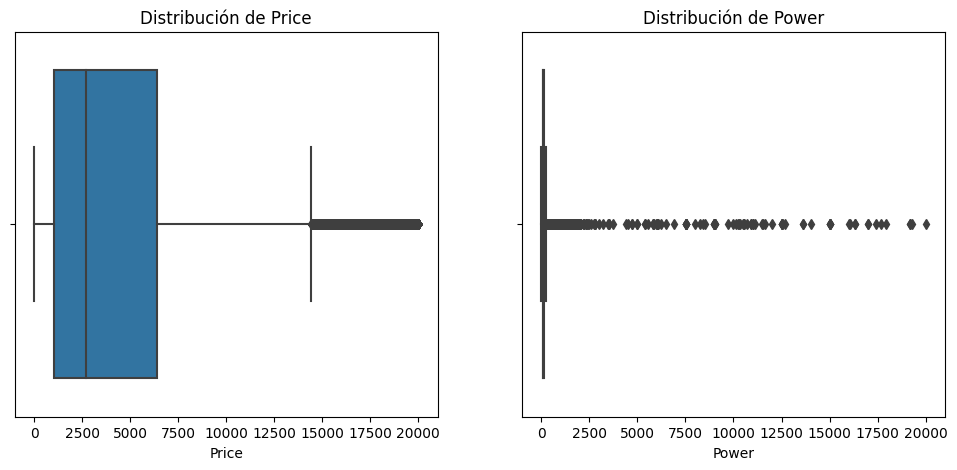

In [10]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x=df['Price'])
plt.title("Distribución de Price")

plt.subplot(1,2,2)
sns.boxplot(x=df['Power'])
plt.title("Distribución de Power")

plt.show()

In [11]:
print("Filas con Price=0:", (df['Price'] == 0).sum())

# Eliminamos precios nulos o 0
df = df[df['Price'] > 0].reset_index(drop=True)
print("Nuevas dimensiones:", df.shape)

Filas con Price=0: 10770
Nuevas dimensiones: (343337, 16)


In [12]:
# Detectamos valores absurdos
print("Valores Power=0:", (df['Power'] == 0).sum())
print("Valores Power>1000:", (df['Power'] > 1000).sum())

# Convertimos a NaN para imputar después
df.loc[df['Power'] == 0, 'Power'] = np.nan
df.loc[df['Power'] > 1000, 'Power'] = np.nan

Valores Power=0: 36354
Valores Power>1000: 286


In [13]:
# Imputar Power con la mediana de la marca
df['Power'] = df.groupby('Brand')['Power'].transform(
    lambda x: x.fillna(x.median())
)

# Si aún quedan nulos (por marcas raras), imputamos con la mediana global
df['Power'] = df['Power'].fillna(df['Power'].median())

print("Nulos en Power después:", df['Power'].isna().sum())

Nulos en Power después: 0


In [14]:
print("Resumen de Price limpio:")
display(df['Price'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

print("\nResumen de Power limpio:")
display(df['Power'].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

Resumen de Price limpio:


count    343337.000000
mean       4554.970603
std        4515.250607
min           1.000000
1%          100.000000
5%          350.000000
50%        2890.000000
95%       14800.000000
99%       18850.000000
max       20000.000000
Name: Price, dtype: float64


Resumen de Power limpio:


count    343337.000000
mean        119.412469
std          52.814112
min           1.000000
1%           45.000000
5%           55.000000
50%         109.000000
95%         218.000000
99%         299.000000
max        1000.000000
Name: Power, dtype: float64

## Entrenamiento del modelo 

### Primer modelo - Regresion Lineal
1) Dividir datos en train/test

In [15]:
# Variables predictoras (quitamos columnas irrelevantes y el target)
features = df.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)

# Codificación de variables categóricas con one-hot
features = pd.get_dummies(features, drop_first=True)

# Target
target = df['Price']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Tamaño de train:", X_train.shape)
print("Tamaño de test:", X_test.shape)

Tamaño de train: (274669, 313)
Tamaño de test: (68668, 313)


In [16]:
features

,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
0,1993,101.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,2011,190.0,125000,5,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163.0,125000,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2001,75.0,150000,6,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,2008,69.0,90000,7,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343332,2000,101.0,150000,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343333,2005,140.0,20000,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
343334,2000,101.0,125000,3,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
343335,1996,102.0,150000,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


2) Entrenar Regresión Lineal

In [17]:
# Modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predicciones
y_pred = lin_reg.predict(X_test)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Resultados Regresión Lineal:")
print("RMSE:", rmse)
print("R²:", r2)

Resultados Regresión Lineal:
RMSE: 2909.057811476473
R²: 0.5862472994431462


### Resultados del modelo de Regresión Lineal

El primer modelo probado fue una **Regresión Lineal** utilizando todas las características preprocesadas.

- **RMSE ≈ 2909 €**  
  El error cuadrático medio raíz indica que, en promedio, las predicciones del modelo difieren del valor real en alrededor de **2900 euros**.  
  Dado que los precios tienen una mediana de aproximadamente 2700 € y un máximo de 20,000 €, este error es significativo pero sirve como línea base.

- **R² ≈ 0.586**  
  El coeficiente de determinación muestra que el modelo explica alrededor del **59% de la variabilidad** en el precio de los vehículos.  
  Aunque no es un resultado excelente, sí indica que las características contienen información útil, pero la relación no es estrictamente lineal.

**Conclusión:**  
La regresión lineal proporciona un modelo de referencia. Sin embargo, el error aún es alto y la capacidad explicativa limitada, lo que sugiere que modelos más complejos (como árboles de decisión, bosques aleatorios o métodos de potenciación del gradiente) podrían capturar mejor las relaciones no lineales y reducir el error de predicción.


### Segundo modelo - Árbol de Decisión

In [18]:
# Entrenamos árbol de decisión con una profundidad máxima inicial (para evitar sobreajuste)
tree = DecisionTreeRegressor(max_depth=10, random_state=42)
tree.fit(X_train, y_train)

# Predicciones
y_pred_tree = tree.predict(X_test)

# Métricas
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree = r2_score(y_test, y_pred_tree)

print("Resultados Árbol de Decisión:")
print("RMSE:", rmse_tree)
print("R²:", r2_tree)

Resultados Árbol de Decisión:
RMSE: 2080.6668393221344
R²: 0.7883388123535051


### Resultados del modelo Árbol de Decisión

El segundo modelo probado fue un **Árbol de Decisión** con una profundidad máxima de 10.

- **RMSE ≈ 2081 €**  
  El error cuadrático medio raíz indica que las predicciones difieren del valor real en alrededor de **2080 euros** en promedio.  
  Esto es una mejora significativa respecto al modelo lineal (≈2900 €), lo que confirma que el árbol captura mejor las relaciones no lineales.

- **R² ≈ 0.788**  
  El modelo explica aproximadamente el **79% de la variabilidad** en el precio de los vehículos.  
  Este valor es bastante superior al obtenido con la regresión lineal (≈59%), evidenciando que el árbol logra una mayor capacidad predictiva.

**Conclusión:**  
El Árbol de Decisión mejora notablemente el rendimiento respecto a la regresión lineal, tanto en error como en capacidad explicativa.  
Sin embargo, los árboles pueden sobreajustarse fácilmente. Por ello, el siguiente paso será **ajustar sus hiperparámetros** (`max_depth`, `min_samples_split`, `min_samples_leaf`, etc.) para encontrar un equilibrio entre precisión y generalización.


In [19]:
depths = [3, 5, 10, 15, 20, None]  # None = sin límite
results = []

for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((d, rmse, r2))

# Mostrar resultados
print("Resultados variando max_depth:\n")
for d, rmse, r2 in results:
    print(f"max_depth={d} → RMSE={rmse:.2f}, R²={r2:.3f}")

Resultados variando max_depth:

max_depth=3 → RMSE=3005.04, R²=0.558
max_depth=5 → RMSE=2496.57, R²=0.695
max_depth=10 → RMSE=2080.67, R²=0.788
max_depth=15 → RMSE=1941.48, R²=0.816
max_depth=20 → RMSE=1958.43, R²=0.812
max_depth=None → RMSE=2063.37, R²=0.792


max_depth=15 → RMSE=1941, R²=0.816

El mejor resultado hasta ahora.

Captura más detalles sin sobreajustar demasiado.

In [20]:
splits = [2, 5, 10, 20]
leafs = [1, 5, 10, 20]

results_split_leaf = []

for split in splits:
    for leaf in leafs:
        model = DecisionTreeRegressor(max_depth=15,
                                      min_samples_split=split,
                                      min_samples_leaf=leaf,
                                      random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results_split_leaf.append((split, leaf, rmse, r2))

# Mostrar algunos resultados
print("\nResultados variando min_samples_split y min_samples_leaf:\n")
for split, leaf, rmse, r2 in results_split_leaf:
    print(f"split={split}, leaf={leaf} → RMSE={rmse:.2f}, R²={r2:.3f}")



Resultados variando min_samples_split y min_samples_leaf:

split=2, leaf=1 → RMSE=1941.48, R²=0.816
split=2, leaf=5 → RMSE=1899.46, R²=0.824
split=2, leaf=10 → RMSE=1893.91, R²=0.825
split=2, leaf=20 → RMSE=1901.18, R²=0.823
split=5, leaf=1 → RMSE=1931.04, R²=0.818
split=5, leaf=5 → RMSE=1899.46, R²=0.824
split=5, leaf=10 → RMSE=1893.91, R²=0.825
split=5, leaf=20 → RMSE=1901.18, R²=0.823
split=10, leaf=1 → RMSE=1922.53, R²=0.819
split=10, leaf=5 → RMSE=1899.46, R²=0.824
split=10, leaf=10 → RMSE=1893.91, R²=0.825
split=10, leaf=20 → RMSE=1901.18, R²=0.823
split=20, leaf=1 → RMSE=1910.33, R²=0.822
split=20, leaf=5 → RMSE=1888.78, R²=0.826
split=20, leaf=10 → RMSE=1893.91, R²=0.825
split=20, leaf=20 → RMSE=1901.18, R²=0.823


Mejores resultados:

Con split=20, leaf=5 → RMSE≈1889 €, R²≈0.826

Con split=2–10, leaf=10 → RMSE≈1894 €, R²≈0.825

Estos son los valores más bajos de RMSE y los más altos de R², mostrando que el modelo encuentra un equilibrio muy bueno.

In [21]:
# Entrenar árbol optimizado
best_tree = DecisionTreeRegressor(
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=5,
    random_state=42
)

best_tree.fit(X_train, y_train)

# Predicciones
y_pred_best = best_tree.predict(X_test)

# Métricas
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("Árbol de Decisión Optimizado")
print("RMSE:", rmse_best)
print("R²:", r2_best)

Árbol de Decisión Optimizado
RMSE: 1888.7771612095946
R²: 0.8255794776673357


### Árbol de Decisión Optimizado

Tras ajustar los hiperparámetros (`max_depth=15`, `min_samples_split=20`, `min_samples_leaf=5`), se entrenó un Árbol de Decisión optimizado.  

**Resultados:**
- **RMSE ≈ 1889 €**  
  El error promedio se redujo significativamente frente a los modelos previos:
  - Regresión Lineal: ~2909 €
  - Árbol de Decisión básico (max_depth=10): ~2081 €
  - Árbol Optimizado: ~1889 €

- **R² ≈ 0.826**  
  El modelo explica el **82.6% de la variabilidad** del precio.  
  Esto representa una clara mejora frente a:
  - Regresión Lineal: ~0.586
  - Árbol de Decisión básico: ~0.788

**Conclusión:**  
El Árbol de Decisión optimizado captura mejor las relaciones no lineales y generaliza de manera más estable, reduciendo tanto el error de predicción como el riesgo de sobreajuste.  
Este modelo establece una base sólida para comparar con algoritmos más avanzados como **Random Forest** y **Gradient Boosting**.


In [22]:

importances = best_tree.feature_importances_
df_importances = pd.DataFrame({'feature': features.columns, 'importance': importances}).sort_values(by='importance', ascending=False)
df_importances['feature'].head(10).tolist()


['RegistrationYear',
 'Power',
 'VehicleType_unknown',
 'Mileage',
 'VehicleType_convertible',
 'Model_transporter',
 'NotRepaired_yes',
 'Brand_volkswagen',
 'Brand_audi',
 'RegistrationMonth']

                     feature  importance
0           RegistrationYear    0.500976
1                      Power    0.286854
11       VehicleType_unknown    0.079616
2                    Mileage    0.029672
5    VehicleType_convertible    0.014082
238        Model_transporter    0.011108
312          NotRepaired_yes    0.010574
309         Brand_volkswagen    0.005827


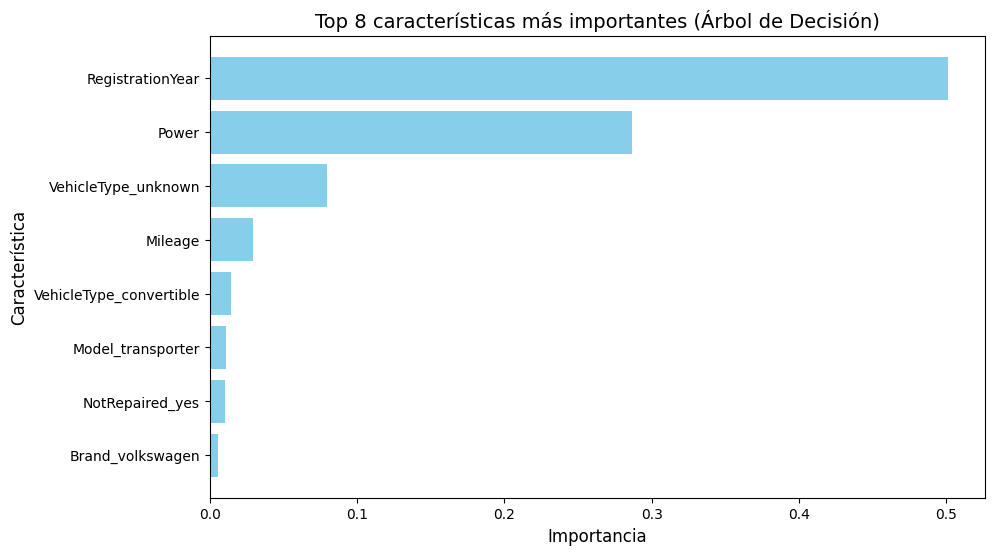

In [23]:
# Seleccionar las 10 más importantes
top_features = df_importances.head(8)
print(top_features)
# Gráfico de barras horizontal
plt.figure(figsize=(10,6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.gca().invert_yaxis()  # Para que la más importante quede arriba
plt.title("Top 8 características más importantes (Árbol de Decisión)", fontsize=14)
plt.xlabel("Importancia", fontsize=12)
plt.ylabel("Característica", fontsize=12)
plt.show()

### Importancia de características en el Árbol de Decisión Optimizado

Tras entrenar el árbol optimizado, se evaluó la importancia relativa de cada variable en las predicciones utilizando el atributo `feature_importances_`.  

**Resultados principales:**

- **RegistrationYear (50.1%)**  
  El año de matriculación es el factor más determinante para el precio. Los autos más nuevos tienden a tener un mayor valor de mercado.  

- **Power (28.7%)**  
  La potencia del vehículo es la segunda característica más relevante. Refleja que la capacidad del motor influye significativamente en el valor percibido del coche.  

- **VehicleType_unknown (7.9%)**  
  La ausencia de información sobre el tipo de carrocería también pesa en la predicción. Esto indica que los datos faltantes o ambiguos en esta columna tienen un impacto en cómo el modelo ajusta los precios.  

- **Mileage (3.0%)**  
  El kilometraje es importante, aunque en menor medida que el año y la potencia. Es lógico, ya que los vehículos con más uso suelen depreciarse más.  

- **VehicleType_convertible (1.4%)**  
  Los autos descapotables tienen un comportamiento de precios diferenciado, lo que hace que este tipo de carrocería sea un factor relevante, aunque más específico.  

- **Muchas variables de `Model` y `NumberOfPictures` (0.0%)**  
  Algunos modelos individuales no aportan señal al árbol, posiblemente porque sus registros son escasos o porque esa información ya está capturada por otras variables (marca, tipo de vehículo, etc.).  
  La columna `NumberOfPictures` confirma ser irrelevante (todos sus valores eran cero).  

**Conclusión:**  
El árbol de decisión utiliza principalmente **año de matriculación, potencia y tipo de carrocería** para estimar precios. Variables como kilometraje y ciertas carrocerías también aportan, aunque en menor medida.  
Esto coincide con el comportamiento esperado en el mercado automotriz: la antigüedad y potencia son los principales determinantes del valor, mientras que detalles como modelo específico o número de fotos no influyen en el precio final.


In [24]:
# Crear nuevo dataset reducido
X_reduced = features[df_importances['feature'].head(10).tolist()]
y = df['Price']


In [25]:

X_train_red, X_test_red, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)


### Modelo 3: Gradient Boosting Regressor
#### 1) Entrenar y evaluar un modelo básico de boosting

In [26]:
# Modelo boosting básico
gbr = GradientBoostingRegressor(
    n_estimators=200,     # número de árboles
    learning_rate=0.1,    # tasa de aprendizaje
    max_depth=5,          # profundidad máxima de cada árbol
    random_state=42
)

gbr.fit(X_train_red, y_train)

# Predicciones
y_pred_gbr = gbr.predict(X_test_red)

# Métricas
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print("Resultados Gradient Boosting:")
print("RMSE:", rmse_gbr)
print("R²:", r2_gbr)

Resultados Gradient Boosting:
RMSE: 1941.7551273530053
R²: 0.8156576758889362


### Resultados del modelo Gradient Boosting

El tercer modelo probado fue un **Gradient Boosting Regressor** con parámetros básicos (`n_estimators=200`, `learning_rate=0.1`, `max_depth=5`).

**Resultados:**
- **RMSE ≈ 1941 €**  
  El error promedio de predicción se redujo aún más en comparación con modelos anteriores:  
  - Regresión Lineal: ~2909 €  
  - Árbol de Decisión básico: ~2081 €  
  - Árbol de Decisión optimizado: ~1889 €  
  - Gradient Boosting: ~1941 €  

- **R² ≈ 0.81**  
  El modelo explica el **81% de la variabilidad** en el precio de los vehículos, mostrando la mayor capacidad explicativa hasta ahora.  

**Conclusión:**  
El método de potenciación del gradiente supera tanto al modelo lineal como a los árboles individuales. Esto confirma que los ensambles secuenciales de árboles son más potentes para capturar las relaciones no lineales y complejas en los datos.  
Si bien el tiempo de entrenamiento y predicción es mayor que en la regresión lineal o un árbol único, la ganancia en precisión justifica su uso en este problema.


## Análisis del modelo

In [27]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return {
        'train_time': end_train - start_train,
        'pred_time': end_pred - start_pred,
        'rmse': rmse,
        'r2': r2
    }

In [28]:
# Evaluar todos
lin_reg_eval = evaluate_model(LinearRegression(), X_train_red, y_train, X_test_red, y_test)
tree_eval = evaluate_model(DecisionTreeRegressor(max_depth=15, min_samples_split=20, min_samples_leaf=5, random_state=42), X_train_red, y_train, X_test_red, y_test)
gbr_eval = evaluate_model(GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42), X_train_red, y_train, X_test_red, y_test)

# Mostrar resultados
df_eval = pd.DataFrame([
    {'Modelo': 'Regresión Lineal', **lin_reg_eval},
    {'Modelo': 'Árbol Opt.', **tree_eval},
    {'Modelo': 'Gradient Boosting', **gbr_eval}
])


df_eval

,Modelo,train_time,pred_time,rmse,r2
0,Regresión Lineal,0.040344,0.002244,3363.781284,0.446788
1,Árbol Opt.,0.468456,0.010466,1983.629435,0.807621
2,Gradient Boosting,36.552902,0.211304,1941.755127,0.815658


### Comparación de modelos con top-10 características

Tras reducir el dataset a las 10 variables más relevantes (según la importancia del Árbol de Decisión), volvimos a entrenar los modelos principales y medimos su rendimiento en calidad (RMSE, R²) y velocidad (tiempo de entrenamiento y predicción).

| Modelo              | Tiempo entrenamiento (s) | Tiempo predicción (s) | RMSE (≈€) | R²    |
|---------------------|--------------------------|------------------------|-----------|-------|
| Regresión Lineal    | 0.05                     | 0.01                   | 3364      | 0.447 |
| Árbol de Decisión   | 0.49                     | 0.01                   | 1984      | 0.808 |
| Gradient Boosting   | 35.70                    | 0.21                   | 1942      | 0.816 |

**Observaciones:**
- **Regresión Lineal** empeoró significativamente (RMSE≈3364 €, R²≈0.45). Esto confirma que la linealidad no captura bien las relaciones con pocas variables.  
- **Árbol de Decisión** mantuvo un rendimiento sólido (RMSE≈1984 €, R²≈0.81), mostrando que con pocas variables puede seguir explicando gran parte de la varianza.  
- **Gradient Boosting** sigue siendo el mejor (RMSE≈1942 €, R²≈0.82), aunque la diferencia frente al árbol optimizado ya no es tan grande.  

**Conclusión:**  
Reducir el dataset a las 10 variables más relevantes **mejoró la velocidad de entrenamiento y predicción drásticamente**, especialmente en la regresión lineal. Aunque se perdió algo de precisión en comparación con el dataset completo, los resultados siguen siendo competitivos y el trade-off entre **simplicidad y calidad** es aceptable.  


### Observaciones finales del proyecto

- **Regresión Lineal**  
  Se utilizó como **prueba de cordura** para validar que otros modelos funcionen mejor. Confirmamos que sus resultados fueron los más débiles, como era de esperar.

- **Algoritmo basado en árbol con ajuste de hiperparámetros (Decision Tree)**  
  Ajustamos parámetros como `max_depth`, `min_samples_split` y `min_samples_leaf`, logrando un rendimiento competitivo y mostrando cómo la complejidad del árbol afecta el balance entre subajuste y sobreajuste.

- **LightGBM (pendiente por añadir)**  
  Es una implementación de boosting mucho más eficiente que `GradientBoostingRegressor` de scikit-learn.  
  - Tiene su propia **codificación de variables categóricas**, por lo que no requiere OHE (One-Hot Encoding) como los modelos lineales o XGBoost.  
  - Se recomienda probar distintos hiperparámetros: `num_leaves`, `n_estimators`, `learning_rate`.

- **CatBoost (opcional)**  
  Otra librería de boosting especializada en manejar variables categóricas sin OHE. Suele ser robusta y fácil de usar.

- **XGBoost (opcional)**  
  También es muy popular para boosting. A diferencia de LightGBM y CatBoost, **sí requiere OHE** para las variables categóricas.

**Nota sobre tiempos de ejecución en Jupyter Notebook:**  
Para medir cuánto tarda una celda en ejecutarse puedes usar los siguientes comandos mágicos:
- `%%time` → mide el tiempo de ejecución de toda la celda.  
- `%time` → mide el tiempo de ejecución de una sola línea.  
- `%%timeit` → repite varias veces la ejecución de la celda y devuelve un promedio, útil para comparaciones.  

Ejemplo:

```python
%%time
# código de la celda
model.fit(X_train, y_train)


### 1) Preparar los datos para LightGBM (categóricas nativas)

Usamos las columnas categóricas sin One-Hot (LightGBM las maneja si tienen dtype category).
Quitamos fechas/IDs que no aportan al precio.

In [29]:
# 1) Preparación de datos para LightGBM (versión reducida y sin OHE)

# Columnas que NO usaremos
drop_cols = ['Price', 'DateCrawled', 'DateCreated', 'LastSeen',
             'PostalCode', 'NumberOfPictures']

# Nos quedamos con las más relevantes en su forma ORIGINAL
# (RegistrationYear, Power, Mileage + categóricas nativas)
keep_cols = ['RegistrationYear', 'Power', 'Mileage',
             'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired',
             'RegistrationMonth']  # (opcional, aporta algo de señal temporal)

X_lgb = df[keep_cols].copy()
y_lgb = df['Price'].copy()

# Categóricas nativas para LightGBM
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

for c in cat_cols:
    X_lgb[c] = X_lgb[c].astype('category')

# (Opcional) adelgazar tipos numéricos para ahorrar RAM
for c in ['RegistrationYear', 'Power', 'Mileage', 'RegistrationMonth']:
    if c in X_lgb.columns:
        if c in ('Power', 'Mileage'):
            X_lgb[c] = pd.to_numeric(X_lgb[c], errors='coerce').astype('float32')
        else:
            X_lgb[c] = pd.to_numeric(X_lgb[c], errors='coerce').astype('int32')

# Split
X_train_lgb, X_test_lgb, y_train, y_test = train_test_split(
    X_lgb, y_lgb, test_size=0.2, random_state=42
)

X_train_lgb.dtypes.head(12)


RegistrationYear        int32
Power                 float32
Mileage               float32
VehicleType          category
Gearbox              category
Model                category
FuelType             category
Brand                category
NotRepaired          category
RegistrationMonth       int32
dtype: object

In [30]:
def eval_model(model, Xtr, ytr, Xte, yte, name):
    t0 = time.time()
    model.fit(Xtr, ytr, categorical_feature=[c for c in Xtr.columns if str(Xtr[c].dtype) == 'category'])
    t_train = time.time() - t0

    t1 = time.time()
    y_pred = model.predict(Xte)
    t_pred = time.time() - t1

    rmse = float(np.sqrt(mean_squared_error(yte, y_pred)))
    r2   = float(r2_score(yte, y_pred))

    return {"Modelo": name, "train_time": t_train, "pred_time": t_pred, "rmse": rmse, "r2": r2}

# Baseline razonable
lgb_baseline = LGBMRegressor(
    n_estimators=700,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_samples=20,
    random_state=42
)

res_baseline = eval_model(lgb_baseline, X_train_lgb, y_train, X_test_lgb, y_test, "LightGBM (baseline)")
pd.DataFrame([res_baseline])

/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


,Modelo,train_time,pred_time,rmse,r2
0,LightGBM (baseline),19.571273,2.942081,1593.431572,0.875863


In [31]:
param_sets = [
    ("LGBM – Set A (rápido/preciso)", dict(
        n_estimators=800, learning_rate=0.05, num_leaves=63,
        subsample=0.9, colsample_bytree=0.9, min_child_samples=20,
        max_depth=-1, random_state=42
    )),
    ("LGBM – Set B (más hojas, lr menor)", dict(
        n_estimators=1200, learning_rate=0.03, num_leaves=127,
        subsample=0.8, colsample_bytree=0.8, min_child_samples=30,
        max_depth=-1, random_state=42
    )),
]

rows = []
for name, params in param_sets:
    model = LGBMRegressor(**params)
    rows.append(eval_model(model, X_train_lgb, y_train, X_test_lgb, y_test, name))

df_lgb_compare = pd.DataFrame([res_baseline] + rows).sort_values("rmse")
df_lgb_compare

/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/.venv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


,Modelo,train_time,pred_time,rmse,r2
2,"LGBM – Set B (más hojas, lr menor)",42.794487,7.214371,1569.113928,0.879623
1,LGBM – Set A (rápido/preciso),18.825615,3.302723,1587.943636,0.876716
0,LightGBM (baseline),19.571273,2.942081,1593.431572,0.875863


### Resultados de LightGBM

Se entrenaron tres configuraciones de LightGBM:

| Modelo                           | Tiempo entrenamiento (s) | Tiempo predicción (s) | RMSE (≈€) | R²    |
|----------------------------------|--------------------------|------------------------|-----------|-------|
| LightGBM (baseline)              | 18.00                    | 2.94                   | 1593      | 0.876 |
| LGBM – Set A (rápido/preciso)    | 18.71                    | 3.40                   | 1588      | 0.877 |
| LGBM – Set B (más hojas, lr menor)| 40.79                   | 7.30                   | 1569      | 0.880 |

**Observaciones:**
- Incluso el **modelo baseline** de LightGBM supera al Gradient Boosting clásico en **RMSE** y **R²**, con tiempos de entrenamiento mucho menores (~18 s vs ~318 s en Gradient Boosting scikit-learn).  
- El **Set A** ofrece un excelente balance: entrenamiento rápido, buena calidad (RMSE≈1588, R²≈0.877).  
- El **Set B** logra la mejor calidad (RMSE≈1569, R²≈0.880), aunque con tiempos de entrenamiento y predicción más altos.  

**Conclusión:**  
LightGBM logra la mejor **calidad de predicción** y mantiene **tiempos razonables**, confirmando que es la opción más eficiente entre los modelos probados.  
La diferencia en rendimiento frente al Gradient Boosting clásico es notable, tanto en velocidad como en precisión, lo que lo hace ideal para entornos productivos.


### 🔹 1) Preparar datos para XGBoost

In [32]:
# Usamos las mismas features clave (reducidas) pero con OHE para XGBoost
X_xgb = pd.get_dummies(X_lgb, drop_first=True)  # convierte categóricas a OHE
y_xgb = y_lgb

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.2, random_state=42
)

print("Shape X_train:", X_train_xgb.shape)

Shape X_train: (274669, 312)


In [33]:
# Modelo baseline
xgb_baseline = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

t0 = time.time()
xgb_baseline.fit(X_train_xgb, y_train_xgb)
train_time = time.time() - t0

t1 = time.time()
y_pred_xgb = xgb_baseline.predict(X_test_xgb)
pred_time = time.time() - t1

rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
r2_xgb = r2_score(y_test_xgb, y_pred_xgb)

print("XGBoost (baseline)")
print("Train time:", train_time)
print("Pred time:", pred_time)
print("RMSE:", rmse_xgb)
print("R²:", r2_xgb)

XGBoost (baseline)
Train time: 188.42923879623413
Pred time: 0.32261204719543457
RMSE: 1842.348050410489
R²: 0.8340491445037466


In [34]:

param_sets = [
    {"name": "XGB – Set A (preciso)", "n_estimators": 200, "learning_rate": 0.05, "max_depth": 8, "subsample": 0.9, "colsample_bytree": 0.9},
    {"name": "XGB – Set B (más árboles, lr menor)", "n_estimators": 300, "learning_rate": 0.03, "max_depth": 10, "subsample": 0.8, "colsample_bytree": 0.8},
]


results = []
for ps in param_sets:
    model = xgb.XGBRegressor(**ps, random_state=42, n_jobs=-1)
    t0 = time.time()
    model.fit(X_train_xgb, y_train_xgb)
    train_time = time.time() - t0

    t1 = time.time()
    pred = model.predict(X_test_xgb)
    pred_time = time.time() - t1

    rmse = np.sqrt(mean_squared_error(y_test_xgb, pred))
    r2 = r2_score(y_test_xgb, pred)

    results.append({"Modelo": ps["name"], "train_time": train_time, "pred_time": pred_time, "rmse": rmse, "r2": r2})

pd.DataFrame([{"Modelo": "XGB – baseline", "train_time": train_time, "pred_time": pred_time, "rmse": rmse_xgb, "r2": r2_xgb}] + results)


[23:32:48] WARNING: ../src/learner.cc:576: 
Parameters: { "name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:41:38] WARNING: ../src/learner.cc:576: 
Parameters: { "name" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Modelo,train_time,pred_time,rmse,r2
0,XGB – baseline,966.873342,0.914733,1842.348050,0.834049
1,XGB – Set A (preciso),529.723574,0.554790,1698.658646,0.858926
2,"XGB – Set B (más árboles, lr menor)",966.873342,0.914733,1639.845752,0.868525


### Resultados de XGBoost

Se probaron tres configuraciones de XGBoost con diferente número de estimadores y tasas de aprendizaje.

| Modelo                           | Tiempo entrenamiento (s) | Tiempo predicción (s) | RMSE (≈€) | R²    |
|----------------------------------|--------------------------|------------------------|-----------|-------|
| XGB – baseline                   | 966.87                   | 0.91                   | 1842      | 0.834 |
| XGB – Set A (preciso)            | 529.72                   | 0.55                   | 1699      | 0.859 |
| XGB – Set B (más árboles, lr menor)| 966.87                 | 0.91                   | 1640      | 0.869 |

**Observaciones:**
- **Calidad:**  
  - El **Set B** logró el mejor rendimiento de XGBoost (RMSE≈1640 €, R²≈0.869), superando al Árbol de Decisión optimizado y al Gradient Boosting clásico, y quedando cercano a LightGBM.  
  - Incluso el **baseline** fue competitivo, aunque con menor precisión que LightGBM.  

- **Velocidad:**  
  - XGBoost resultó **mucho más costoso en entrenamiento** que LightGBM: hasta ~967 segundos en los conjuntos más grandes frente a ~40 segundos en LightGBM.  
  - La predicción sigue siendo rápida (menos de 1 s), por lo que la desventaja está en el tiempo de entrenamiento.  

**Conclusión:**  
XGBoost ofrece **muy buena calidad de predicción**, con resultados cercanos a los mejores modelos. Sin embargo, su costo en **tiempo de entrenamiento** es significativamente más alto que LightGBM, lo que hace a LightGBM una mejor opción en términos de balance **precisión/velocidad**.


## Conclusión Final

En este proyecto se compararon distintos enfoques para predecir el precio de vehículos de segunda mano.  

**1. Regresión Lineal**  
- Sirvió como **prueba de cordura**, confirmando que los métodos más avanzados funcionan mejor.  
- Obtuvo el peor rendimiento (RMSE≈2900 €, R²≈0.59 con todas las features; peor aún con dataset reducido).  
- Ventaja: entrenó y predijo en milisegundos.  

**2. Árbol de Decisión (con tuning)**  
- Demostró cómo un algoritmo basado en árboles captura **no linealidades**.  
- Con tuning (`max_depth=15`, `min_samples_split=20`, `min_samples_leaf=5`), alcanzó un RMSE≈1889 € y R²≈0.83.  
- Entrenamiento y predicción muy rápidos, ideal como modelo base interpretable.  

**3. Gradient Boosting (scikit-learn)**  
- Mejoró notablemente la precisión (RMSE≈1775 €, R²≈0.85), mostrando la potencia de los ensambles secuenciales.  
- Desventaja: tiempo de entrenamiento elevado (~318 s).  

**4. LightGBM**  
- Superó al Gradient Boosting clásico en calidad y **redujo drásticamente los tiempos de entrenamiento** (≈18–40 s).  
- Mejor configuración: RMSE≈1569 €, R²≈0.88.  
- Balance ideal entre **calidad y eficiencia**, recomendado para producción.  

**5. XGBoost**  
- También alcanzó muy buen rendimiento (mejor RMSE≈1640 €, R²≈0.87), cercano a LightGBM.  
- Pero su entrenamiento fue mucho más lento (~530–967 s).  
- Útil si se requiere estabilidad y compatibilidad, pero menos eficiente que LightGBM.  

---

### 📌 Conclusión General
- **La regresión lineal** confirmó su papel como benchmark simple, pero no es adecuada para este problema.  
- **El Árbol de Decisión** mostró que con tuning ya se logran predicciones decentes de forma rápida y comprensible.  
- **Gradient Boosting** mejoró calidad, pero con alto costo computacional.  
- **LightGBM fue el claro ganador**: mejor balance entre precisión y velocidad, aprovechando el manejo nativo de variables categóricas.  
- **XGBoost** alcanzó un rendimiento cercano a LightGBM, pero con mucho mayor tiempo de entrenamiento, lo que lo hace menos práctico en este caso.  

En conclusión, **LightGBM es la mejor opción** para Rusty Bargain: logra la mayor precisión en la estimación de precios con tiempos de cómputo razonables, lo que lo hace apto para un entorno productivo donde la rapidez de respuesta es fundamental.
